<a href="https://colab.research.google.com/github/yash1thsa/machine_learning_pipelines/blob/main/HelmNet_Full_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 43.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
import os
import random
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras import callbacks                                            # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse                                                 # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = np.load('/content/drive/MyDrive/images_proj.npy')

labels = pd.read_csv('/content/drive/MyDrive/Labels_proj.csv')

In [ ]:
print(images.shape)
print(labels.shape)

(631, 200, 200, 3)
(631, 1)


# **Exploratory Data Analysis**

###Plot random images from each of the classes and print their corresponding labels.

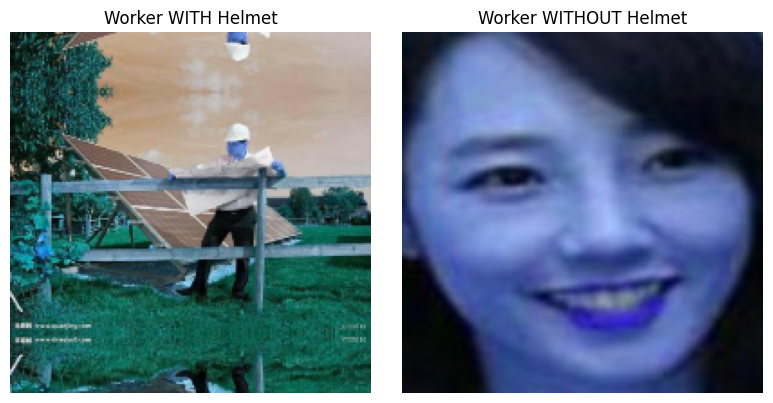

In [ ]:
helmet_indices = np.where(labels == 1)[0]
no_helmet_indices = np.where(labels == 0)[0]

# Select one image from each class
helmet_img = images[np.random.choice(helmet_indices)]
no_helmet_img = images[np.random.choice(no_helmet_indices)]

# Plot the images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display "With Helmet" image
axes[0].imshow(helmet_img)
axes[0].set_title("Worker WITH Helmet")
axes[0].axis('off')

# Display "Without Helmet" image
axes[1].imshow(no_helmet_img)
axes[1].set_title("Worker WITHOUT Helmet")
axes[1].axis('off')

# Show the plots
plt.tight_layout()
plt.show()

## Checking for class imbalance


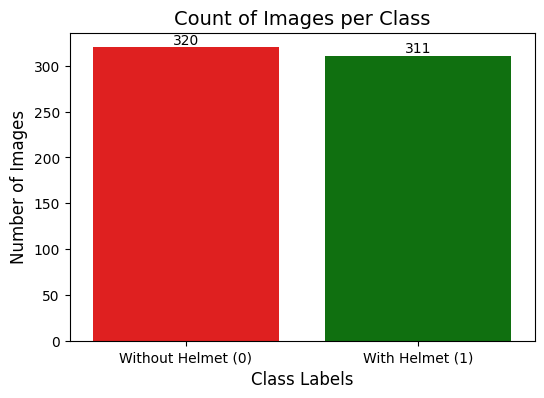

In [ ]:
# Create a count plot
plt.figure(figsize=(6, 4))
ax = sns.countplot(x=labels.iloc[:, 0], palette=['red', 'green'])

# Add exact counts on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10, )

# Add labels
plt.xlabel("Class Labels", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Count of Images per Class", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Without Helmet (0)", "With Helmet (1)"])
# Show plot
plt.show()

# **Data Preprocessing**

## Converting images to grayscale

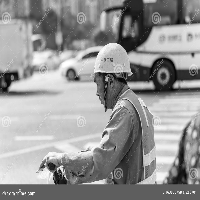

In [ ]:
images_gray = []
for i in range(len(images)):
    img_gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    images_gray.append(img_gray)

# Display a sample grayscale image
n = random.randint(0, len(images_gray))
cv2_imshow(images_gray[n])

### Splitting the dataset



In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images),labels , test_size=0.4, random_state=42,stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp , test_size=0.5, random_state=42,stratify=y_temp)

### Data Normalization

In [ ]:
X_train_normalized = X_train.astype('float32')/255
X_val_normalized = X_val.astype('float32')/255
X_test_normalized = X_test.astype('float32')/255

# **Model Building**

##Model Evaluation Criterion

## Utility Functions

In [ ]:
# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)


    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred, average='weighted')  # to compute Recall
    precision = precision_score(target, pred, average='weighted')  # to compute Precision
    f1 = f1_score(target, pred, average='weighted')  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame({"Accuracy": acc, "Recall": recall, "Precision": precision, "F1 Score": f1,},index=[0],)

    return df_perf

In [ ]:
def plot_confusion_matrix(model,predictors,target,ml=False):
    """
    Function to plot the confusion matrix

    model: classifier
    predictors: independent variables
    target: dependent variable
    ml: To specify if the model used is an sklearn ML model or not (True means ML model)
    """

    # checking which probabilities are greater than threshold
    pred = model.predict(predictors).reshape(-1)>0.5

    target = target.to_numpy().reshape(-1)

    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    confusion_matrix = tf.math.confusion_matrix(target,pred)
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        ax=ax
    )
    plt.show()

##Model 1: Simple Convolutional Neural Network (CNN)

In [ ]:
# Initializing Model
model_1 = Sequential()

# --- Convolutional Layers ---
model_1.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200, 200, 3)))
model_1.add(MaxPooling2D((2, 2), padding='same'))
model_1.add(Dropout(0.2))   # prevents early overfitting

model_1.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_1.add(MaxPooling2D((2, 2), padding='same'))
model_1.add(Dropout(0.3))   # moderate regularization

model_1.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model_1.add(Dropout(0.4))   # stronger regularization in deeper layer

# --- Flatten and Dense Layers ---
model_1.add(Flatten())
model_1.add(Dense(64, activation='relu'))
model_1.add(Dropout(0.5))   # helps generalize before output layer
model_1.add(Dense(1, activation='sigmoid'))  # binary classification output

# --- Compile the Model ---
opt = Adam(learning_rate=1e-3)
model_1.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=["accuracy", "Recall"])

# --- Summary ---
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    20,480,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,573,377 (78.48 MB)

 Trainable params: 20,573,377 (78.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5),
]

history_1 = model_1.fit(
            X_train_normalized, y_train,
            epochs=60,
            validation_data=(X_val_normalized,y_val),
            shuffle=True,
            batch_size=16,
            verbose=2,
            callbacks=cb
)

Epoch 1/60
24/24 - 17s - 712ms/step - Recall: 0.6398 - accuracy: 0.6587 - loss: 1.0807 - val_Recall: 0.6129 - val_accuracy: 0.8095 - val_loss: 0.4026 - learning_rate: 1.0000e-03
Epoch 2/60
24/24 - 1s - 40ms/step - Recall: 0.9194 - accuracy: 0.9392 - loss: 0.2011 - val_Recall: 0.9032 - val_accuracy: 0.9524 - val_loss: 0.1290 - learning_rate: 1.0000e-03
Epoch 3/60
24/24 - 1s - 55ms/step - Recall: 0.9462 - accuracy: 0.9630 - loss: 0.1373 - val_Recall: 0.9839 - val_accuracy: 0.9921 - val_loss: 0.0408 - learning_rate: 1.0000e-03
Epoch 4/60
24/24 - 1s - 44ms/step - Recall: 0.9785 - accuracy: 0.9815 - loss: 0.0624 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0269 - learning_rate: 1.0000e-03
Epoch 5/60
24/24 - 1s - 34ms/step - Recall: 0.9946 - accuracy: 0.9921 - loss: 0.0384 - val_Recall: 0.9839 - val_accuracy: 0.9921 - val_loss: 0.0168 - learning_rate: 1.0000e-03
Epoch 6/60
24/24 - 1s - 31ms/step - Recall: 0.9839 - accuracy: 0.9921 - loss: 0.0161 - val_Recall: 0.9516 - val_accura

In [ ]:
print (history_1.history.values())

dict_values([[0.6397849321365356, 0.9193548560142517, 0.9462365508079529, 0.9784946441650391, 0.9946236610412598, 0.9838709831237793, 0.9838709831237793, 1.0, 1.0, 1.0, 1.0, 1.0], [0.658730149269104, 0.9391534328460693, 0.9629629850387573, 0.9814814925193787, 0.9920634627342224, 0.9920634627342224, 0.9920634627342224, 1.0, 1.0, 1.0, 1.0, 1.0], [1.08070707321167, 0.20106284320354462, 0.13726530969142914, 0.06238643825054169, 0.03841472417116165, 0.01605386659502983, 0.008069051429629326, 0.003536171978339553, 0.002145530888810754, 0.002596082165837288, 0.004027576185762882, 0.0058174761943519115], [0.6129032373428345, 0.9032257795333862, 0.9838709831237793, 1.0, 0.9838709831237793, 0.9516128897666931, 0.9838709831237793, 0.9516128897666931, 0.9516128897666931, 0.9516128897666931, 0.9516128897666931, 0.9516128897666931], [0.8095238208770752, 0.9523809552192688, 0.9920634627342224, 1.0, 0.9920634627342224, 0.976190447807312, 0.9920634627342224, 0.976190447807312, 0.976190447807312, 0.9761

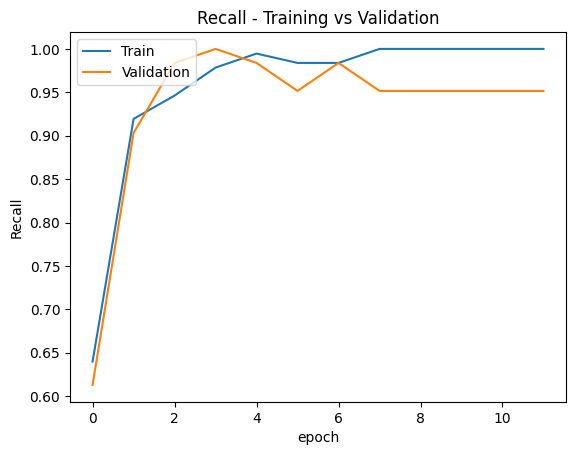

In [ ]:
plt.plot(history_1.history['Recall'])
plt.plot(history_1.history['val_Recall'])
plt.title('Recall - Training vs Validation')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_1_train_perf = model_performance_classification(model_1, X_train_normalized,y_train)

print("Train performance metrics")
print(model_1_train_perf)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


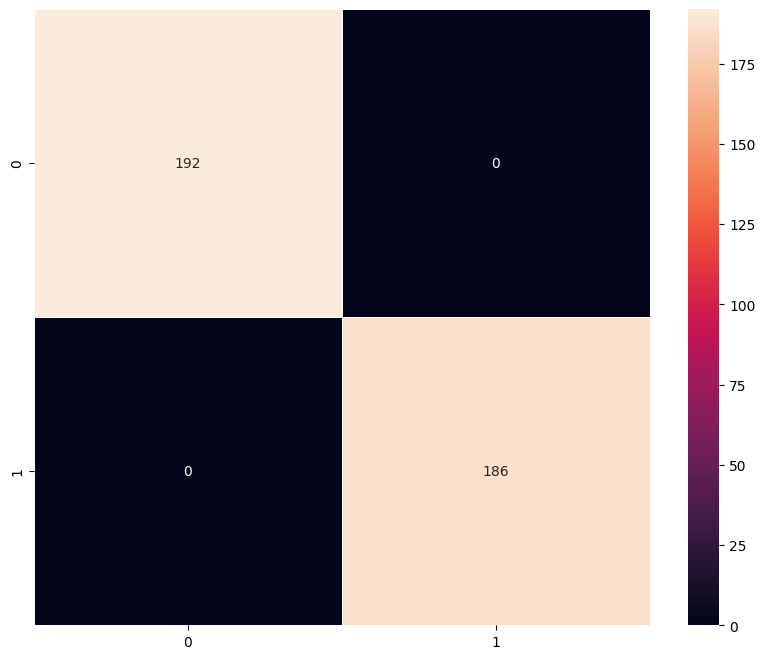

In [ ]:
plot_confusion_matrix(model_1,X_train_normalized,y_train)


In [ ]:
model_1_valid_perf = model_performance_classification(model_1, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_1_valid_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step
Validation performance metrics
   Accuracy    Recall  Precision  F1 Score
0  0.992063  0.992063   0.992186  0.992062


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


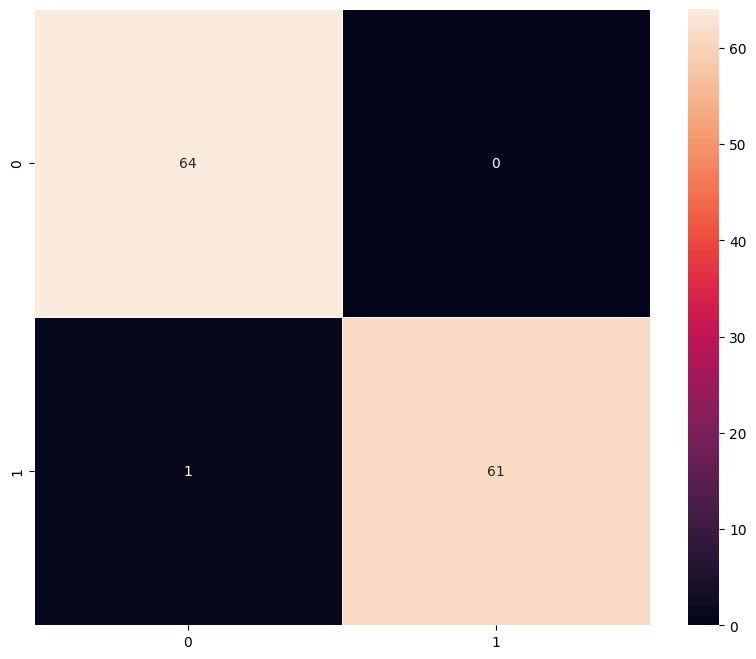

In [ ]:
plot_confusion_matrix(model_1,X_val_normalized,y_val)

### Vizualizing the predictions

In [ ]:
print(X_val_normalized[2].reshape(1,200,200,3))
type( X_val_normalized[2].reshape(1,200,200,3))

[[[[0.6627451  0.60784316 0.6       ]
   [0.19215687 0.15686275 0.14901961]
   [0.5254902  0.52156866 0.52156866]
   ...
   [0.9764706  0.95686275 0.94509804]
   [0.9764706  0.95686275 0.94509804]
   [0.9764706  0.95686275 0.94509804]]

  [[0.40784314 0.36078432 0.3529412 ]
   [0.34509805 0.3137255  0.3019608 ]
   [0.4392157  0.42745098 0.42352942]
   ...
   [0.9764706  0.95686275 0.94509804]
   [0.9764706  0.95686275 0.94509804]
   [0.9764706  0.95686275 0.94509804]]

  [[0.58431375 0.5372549  0.5294118 ]
   [0.3372549  0.30588236 0.29411766]
   [0.4392157  0.42745098 0.42352942]
   ...
   [0.9764706  0.95686275 0.94509804]
   [0.9764706  0.95686275 0.94509804]
   [0.9764706  0.95686275 0.94509804]]

  ...

  [[0.7490196  0.73333335 0.7294118 ]
   [0.9843137  0.96862745 0.9647059 ]
   [0.98039216 0.9647059  0.9607843 ]
   ...
   [0.972549   0.9529412  0.9411765 ]
   [0.972549   0.9529412  0.9411765 ]
   [0.972549   0.9529412  0.9411765 ]]

  [[0.63529414 0.61960787 0.6156863 ]
   [0.9

numpy.ndarray

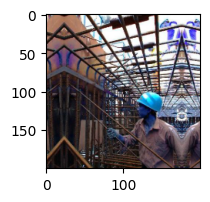

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Label: 1
True Label: Label    1
Name: 244, dtype: int64


In [ ]:
# For index 2
plt.figure(figsize=(2,2))
plt.imshow(X_val[12])
plt.show()
prediction = model_1.predict(X_val_normalized[2].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[12]
print('True Label:', true_label)

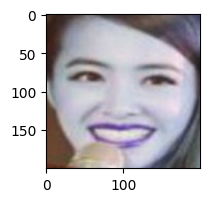

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: 0
True Label: Label    0
Name: 329, dtype: int64


In [ ]:

# For index 33
plt.figure(figsize=(2,2))
plt.imshow(X_val[33])
plt.show()
prediction = model_1.predict(X_val_normalized[33].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[33]
print('True Label:', true_label)

## Model 2: (VGG-16 (Base))

In [ ]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))
vgg_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [ ]:
model_2 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_2.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_2.add(Flatten())

# Adding a dense output layer
model_2.add(Dense(1, activation='sigmoid'))

In [ ]:
opt=Adam(learning_rate=1e-3)
# Compile model
model_2.compile(optimizer=opt, loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "Recall"])

In [ ]:
# Generating the summary of the model
model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator()

In [ ]:
cb = [
    callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-5),
]


# Epochs
epochs = 60
# Batch size
batch_size = 16

history_2 = model_2.fit(train_datagen.flow(X_train_normalized,y_train,
                                      batch_size=batch_size,
                                      seed=42,
                                      shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1, callbacks=cb)

Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 692ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0039 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0045 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0022 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0023 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0014 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step 

In [ ]:
print (history_2.history.keys())

dict_keys(['Recall', 'accuracy', 'loss', 'val_Recall', 'val_accuracy', 'val_loss', 'learning_rate'])


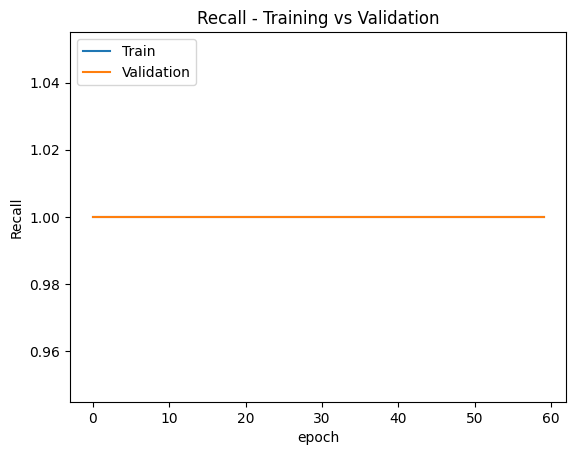

In [ ]:
plt.plot(history_2.history['Recall'])
plt.plot(history_2.history['val_Recall'])
plt.title('Recall - Training vs Validation')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_2_train_perf = model_performance_classification(model_2,X_train_normalized,y_train)

print("Train performance metrics")
print(model_2_train_perf)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


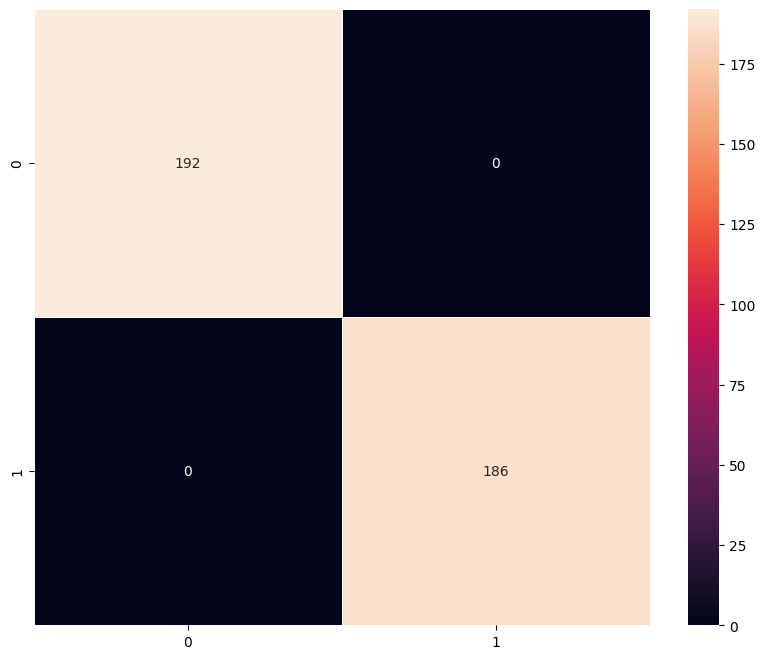

In [ ]:
plot_confusion_matrix(model_2,X_train_normalized,y_train)

In [ ]:
model_2_valid_perf = model_performance_classification(model_2, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_2_valid_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


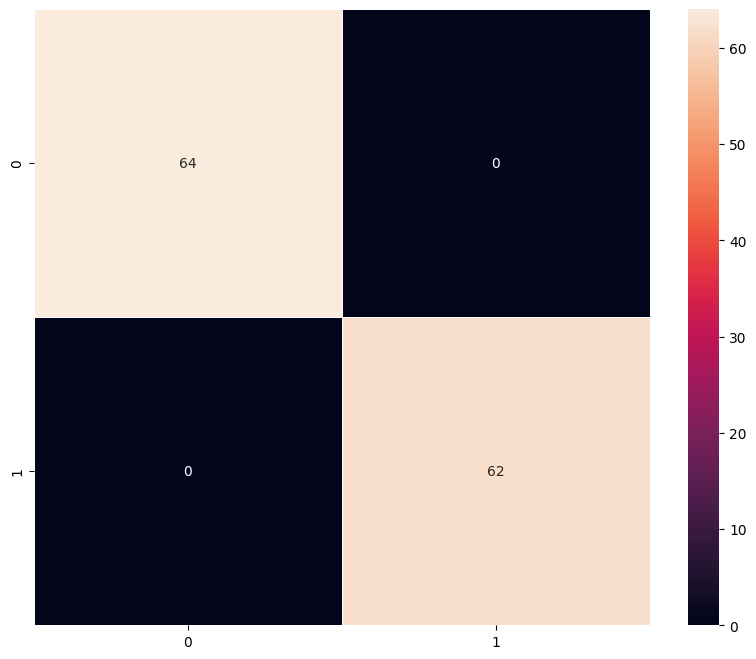

In [ ]:
plot_confusion_matrix(model_2,X_val_normalized,y_val)

### Visualizing the prediction:

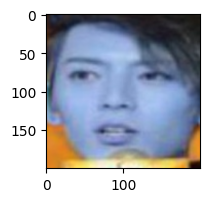

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Label: 0
True Label: Label    0
Name: 535, dtype: int64


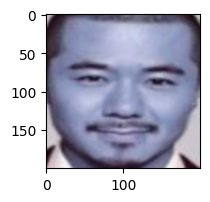

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Label: 0
True Label: Label    0
Name: 593, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[5]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[5].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[5] #Complete the code to define the index
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[22]) #Complete the code to define the index
plt.show()
prediction = model_2.predict(X_val_normalized[22].reshape(1,200,200,3)) #Complete the code to define the index
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[22] #Complete the code to define the index
print('True Label:', true_label)

## Model 3: (VGG-16 (Base + FFNN))

In [ ]:
model_3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_3.add(Flatten())

#Adding the Feed Forward neural network
model_3.add(Dense(32,activation='relu'))
model_3.add(Dropout(rate=0.2))
model_3.add(Dense(64,activation='relu'))

# Adding a dense output layer
model_3.add(Dense(1, activation='sigmoid'))

In [ ]:
opt = Adam(learning_rate=1e-3)

In [ ]:
# Compile model
model_3.compile(optimizer=opt,loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "Recall"])

In [ ]:
# Generating the summary of the model
model_3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,306,721 (58.39 MB)

 Trainable params: 592,033 (2.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_3 = model_3.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=16, #Complete the code to define the batch size
                                       seed=42,
                                       shuffle=False),
                    epochs=60, #Complete the code to define the number of epochs
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - Recall: 0.8449 - accuracy: 0.8670 - loss: 0.2970 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0090 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - Recall: 1.0000 - accuracy: 0.9996 - loss: 0.0072 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 7.4431e-04 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0027
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0033 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.2178e-04
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0028 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 5.116

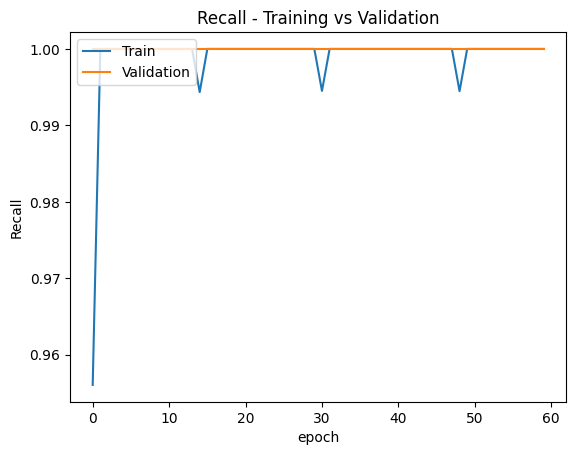

In [ ]:
plt.plot(history_3.history['Recall'])
plt.plot(history_3.history['val_Recall'])
plt.title('Recall - Training vs Validation')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_3_train_perf = model_performance_classification(model_3, X_train_normalized,y_train)

print("Train performance metrics")
print(model_3_train_perf)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


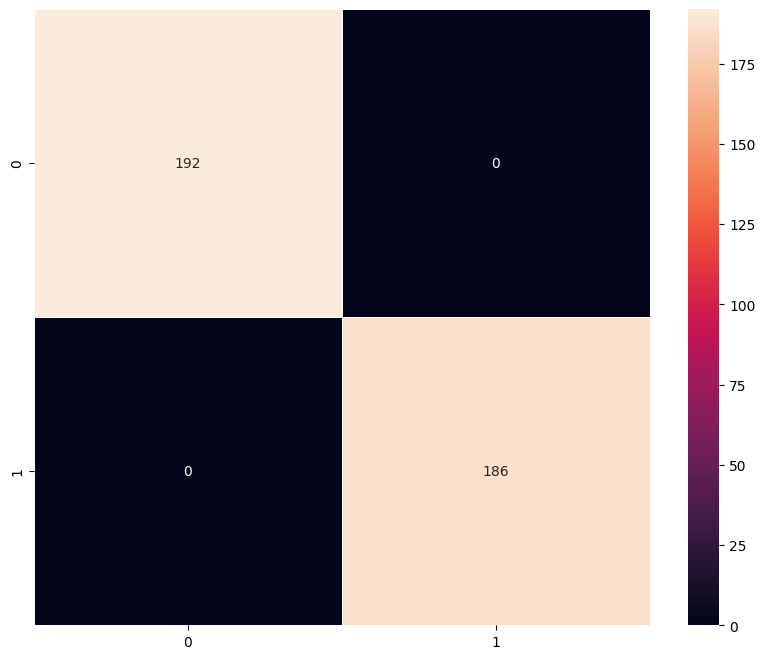

In [ ]:
plot_confusion_matrix(model_3,X_train_normalized,y_train)

In [ ]:
model_3_valid_perf = model_performance_classification(model_3, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_3_valid_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


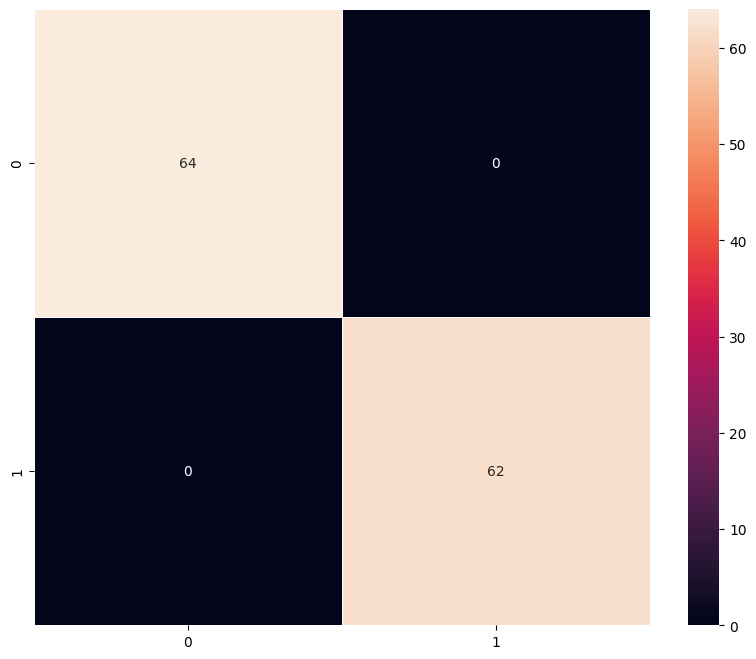

In [ ]:
plot_confusion_matrix(model_3,X_val_normalized,y_val)

#### Visualizing the predictions

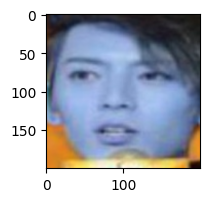

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Predicted Label: 0
True Label: Label    0
Name: 535, dtype: int64


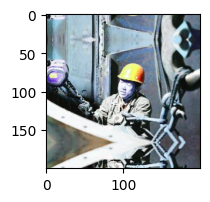

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Label: 1
True Label: Label    1
Name: 88, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[5])
plt.show()
prediction = model_3.predict(X_val_normalized[5].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[5]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[64])
plt.show()
prediction = model_3.predict(X_val_normalized[64].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5  # Extract the predicted class label
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[64]
print('True Label:', true_label)

## Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs.
- To overcome this problem, one approach we might consider is **Data Augmentation**.
- CNNs have the property of **translational invariance**, which means they can recognise an object even if its appearance shifts translationally in some way. - Taking this attribute into account, we can augment the images using the techniques listed below

    -  Horizontal Flip (should be set to True/False)
    -  Vertical Flip (should be set to True/False)
    -  Height Shift (should be between 0 and 1)
    -  Width Shift (should be between 0 and 1)
    -  Rotation (should be between 0 and 180)
    -  Shear (should be between 0 and 1)
    -  Zoom (should be between 0 and 1) etc.

Remember, **data augmentation should not be used in the validation/test data set**.

In [ ]:
model_4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_4.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_4.add(Flatten())

#Adding the Feed Forward neural network
model_4.add(Dense(32,activation='relu'))
model_4.add(Dropout(rate=0.2))
model_4.add(Dense(64,activation='relu'))

# Adding a dense output layer
model_4.add(Dense(1, activation='sigmoid'))

In [ ]:
opt=Adam(learning_rate=1e-3)
# Compile model
model_4.compile(optimizer=opt,   loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy", "Recall"])

In [ ]:
# Generating the summary of the model
model_4.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │       589,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,306,721 (58.39 MB)

 Trainable params: 592,033 (2.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=12,          # small tilts like head/camera wobble
    fill_mode='nearest',        # plausible pixels at the edges after transforms
    width_shift_range=0.10,     # up to 10% left/right — worker not always centered
    height_shift_range=0.10,    # up to 10% up/down — framing differences
    shear_range=10,             # ≈10° slant to mimic viewpoint skew
    zoom_range=[0.85, 1.15]     # 15% zoom in/out — distance to camera varies
)

In [ ]:
history_4 = model_4.fit(train_datagen.flow(X_train_normalized,y_train,
                                       batch_size=16, #Complete the code to define the batch size
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val),
                    verbose=1)

Epoch 1/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - Recall: 0.6765 - accuracy: 0.7645 - loss: 0.3850 - val_Recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 2/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 6.6432e-04 - val_Recall: 1.0000 - val_accuracy: 0.9921 - val_loss: 0.0077
Epoch 3/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 185ms/step - Recall: 1.0000 - accuracy: 0.9949 - loss: 0.0189 - val_Recall: 1.0000 - val_accuracy: 0.9921 - val_loss: 0.0064
Epoch 4/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 0.0017 - val_Recall: 1.0000 - val_accuracy: 0.9921 - val_loss: 0.0067
Epoch 5/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - Recall: 0.9928 - accuracy: 0.9965 - loss: 0.0138 - val_Recall: 1.0000 - val_accuracy: 0.9921 - val_loss: 0.0079
Epoch 6/60
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - Recall: 1.0000 - accuracy: 1.0000 - loss: 9.1577e-04 - val_Recall: 1.0000 - val_accuracy: 0.9921 - val_loss: 0.008

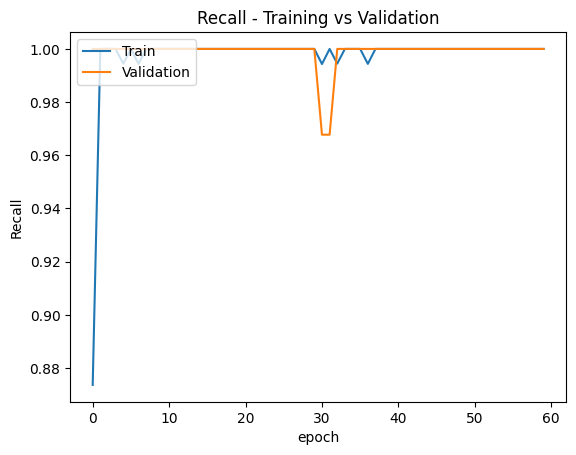

In [ ]:

plt.plot(history_4.history['Recall'])
plt.plot(history_4.history['val_Recall'])
plt.title('Recall - Training vs Validation')
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_4_train_perf = model_performance_classification(model_4, X_train_normalized,y_train)

print("Train performance metrics")
print(model_4_train_perf)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step
Train performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step


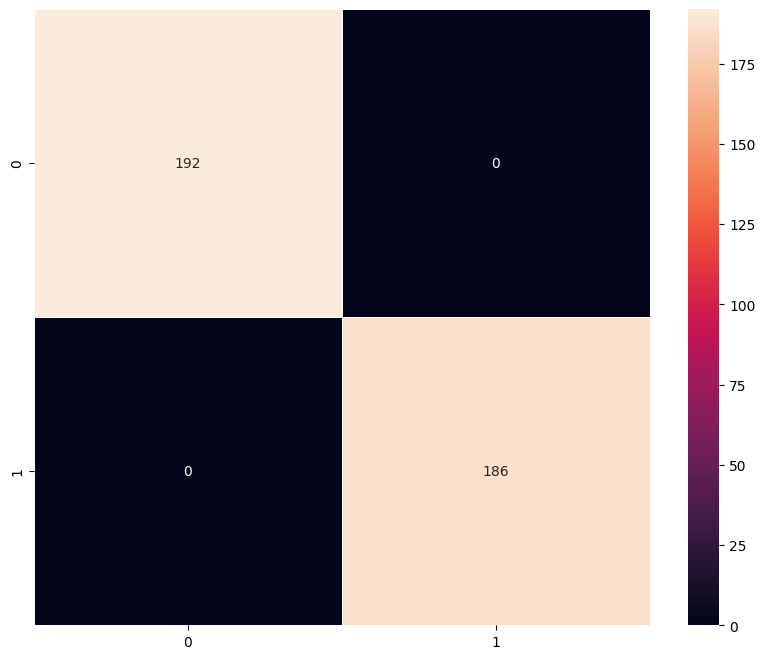

In [ ]:
plot_confusion_matrix(model_4,X_train_normalized,y_train)

In [ ]:
model_4_valid_perf = model_performance_classification(model_4, X_val_normalized,y_val)

print("Validation performance metrics")
print(model_4_valid_perf)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
Validation performance metrics
   Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


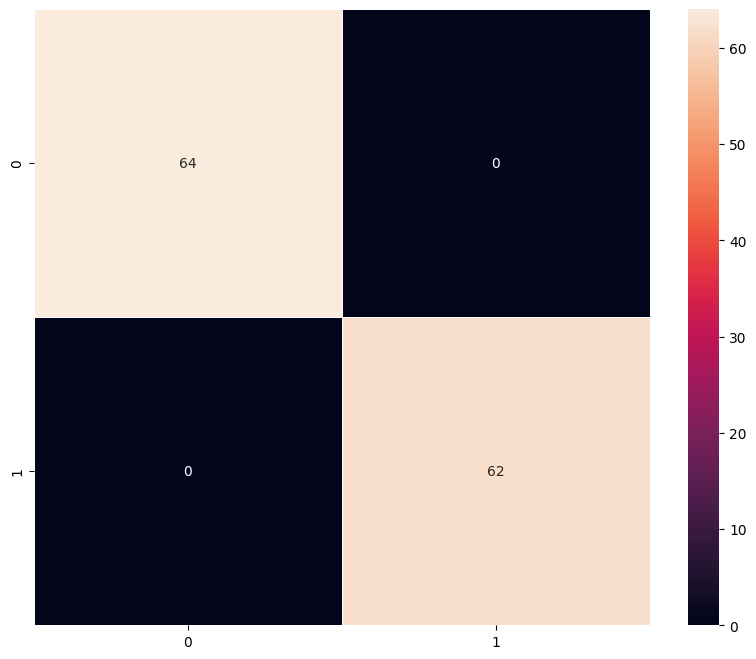

In [ ]:
plot_confusion_matrix(model_4,X_val_normalized,y_val)

#### Visualizing the predictions

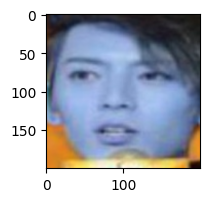

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Label: 0
True Label: Label    0
Name: 535, dtype: int64


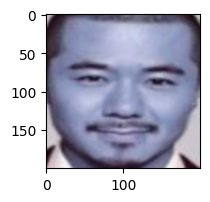

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted Label: 0
True Label: Label    0
Name: 593, dtype: int64


In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(X_val[5])
plt.show()
prediction = model_2.predict(X_val_normalized[5].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[5]
print('True Label:', true_label)

plt.figure(figsize=(2,2))
plt.imshow(X_val[22])
plt.show()
prediction = model_2.predict(X_val_normalized[5].reshape(1,200,200,3))
predicted_label = prediction[0][0]>0.5
print('Predicted Label:', 1 if predicted_label else 0)
# Fix indexing issue in y_val
true_label = y_val.iloc[22]
print('True Label:', true_label)

# **Model Performance Comparison and Final Model Selection**

In [ ]:
models_train_comp_df = pd.concat(
    [
        model_1_train_perf.T,
        model_2_train_perf.T,
        model_3_train_perf.T,
        model_4_train_perf.T,
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_valid_comp_df = pd.concat(
    [
        model_1_valid_perf.T,
        model_2_valid_perf.T,
        model_3_valid_perf.T,
        model_4_valid_perf.T

    ],
    axis=1,
)
models_valid_comp_df.columns = [
 "Simple Convolutional Neural Network (CNN)","VGG-16 (Base)","VGG-16 (Base+FFNN)","VGG-16 (Base+FFNN+Data Aug)"
]

In [ ]:
models_train_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0
F1 Score,1.0,1.0,1.0,1.0


In [ ]:
models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.992063,1.0,1.0,1.0
Recall,0.992063,1.0,1.0,1.0
Precision,0.992186,1.0,1.0,1.0
F1 Score,0.992062,1.0,1.0,1.0


In [ ]:
models_train_comp_df - models_valid_comp_df

,Simple Convolutional Neural Network (CNN),VGG-16 (Base),VGG-16 (Base+FFNN),VGG-16 (Base+FFNN+Data Aug)
Accuracy,0.007937,0.0,0.0,0.0
Recall,0.007937,0.0,0.0,0.0
Precision,0.007814,0.0,0.0,0.0
F1 Score,0.007938,0.0,0.0,0.0


## Test Performance

In [ ]:
model_test_perf = model_performance_classification(model_4, X_test_normalized,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step


In [ ]:
model_test_perf

,Accuracy,Recall,Precision,F1 Score
0,0.992126,0.992126,0.992249,0.992126


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


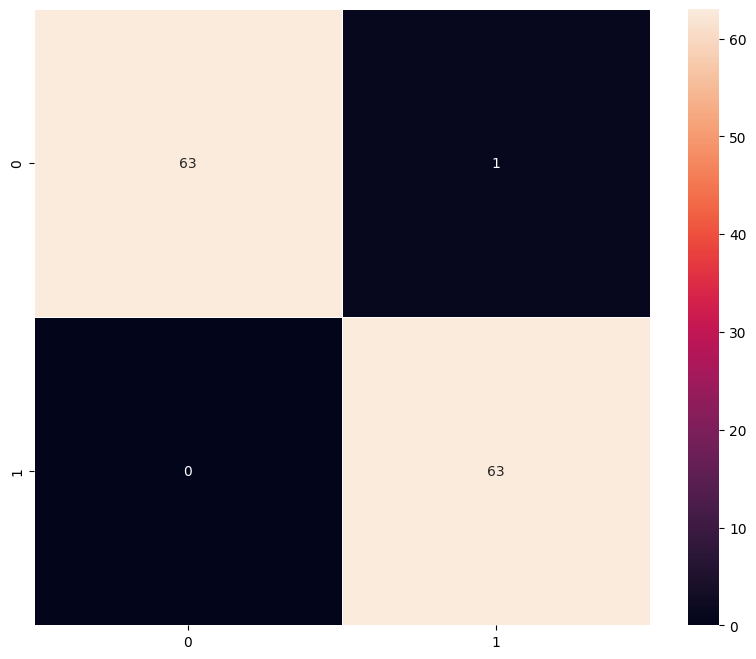

In [ ]:
plot_confusion_matrix(model_4, X_test_normalized,y_test)

# **Actionable Insights & Recommendations**

1) Model strategy
Use transfer learning as your primary model: VGG16 (or EfficientNetB0) with include_top=False, GlobalAveragePooling2D, and a small FFNN head.
Head: GAP → Dense(64, ReLU) → Dropout(0.5) → Dense(1, Sigmoid).
Why: Far fewer params than Flatten, lower overfitting risk on 631 images, faster convergence.
Training schedule:
Stage 1 (frozen base): Adam(1e-3); train head only.
Stage 2 (fine-tune): unfreeze top conv block; Adam(1e-5); short fine-tune.
Keep the simple CNN as a baseline (sanity check + edge device fallback), but expect transfer learning to outperform.
2) Inputs & preprocessing
VGG/EfficientNet path: use RGB (3-channel) inputs even if original is grayscale (duplicate channels), and apply the correct preprocess_input for the chosen backbone.
From-scratch CNN path: grayscale (200,200,1) is fine; standardize to float32 in [0,1].
3) Data splits & leakage control
Stratified 70/15/15 split by class (~441/95/95).
If you have near-duplicate frames or same scene/camera bursts, group them so all shots from the same scene stay in the same split to avoid optimistic metrics.
4) Augmentation (balanced, label-safe)
rotation_range=12, width_shift_range=0.10, height_shift_range=0.10,
shear_range=10, zoom_range=[0.85, 1.15], horizontal_flip=True,
brightness_range=[0.8, 1.2], fill_mode='nearest'
Why: Matches real-world camera/pose/light variations without breaking helmet semantics.
5) Regularization choices that matter
Prefer GAP over Flatten on the TL model.
Dropout schedule: 0.3–0.5 in the head (e.g., 0.5 before output).
(Optional) mild L2 (e.g., 1e-4) on Dense layers if you still see overfitting.
6) Batch size & epochs
Batch: start at 16; move to 8 if jittery/overfitting or GPU memory is tight; try 32 if too noisy/slow.
Epochs: cap 60–80 but always use:
EarlyStopping(patience=7, restore_best_weights=True)
ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-5)
Expect head training to converge in ~10–20 effective epochs; fine-tuning another ~5–10.
7) Metrics & operating threshold (safety-driven)
Track: accuracy, precision, recall, AUC.
Because missing a “no-helmet” is costly, optimize recall on the “no-helmet” class.
After training, tune decision threshold via PR curve:
pick threshold giving recall ≥ target (e.g., 0.95) while keeping tolerable precision.
Document the chosen threshold and rationale.
8) Evaluation protocol
Always report: confusion matrix, PR/ROC curves, and metrics at the chosen threshold.
If possible, do k-fold CV (e.g., 5-fold, grouped by scene) to quantify variance.
9) Error analysis & explainability
Use Grad-CAM on false positives/negatives:
Verify attention is on helmet/head region, not background clutter (cranes, sky, signs).
If attention is off, consider tighter crops (see next item).
10) Multi-person / busy scenes (next step in pipeline)
For frames with multiple workers, pair the classifier with a person/head detector pipeline:
Detector (e.g., lightweight YOLO) to crop each person/head → feed each crop to the classifier.
This reduces background bias and improves per-person decisions.
Longer-term: consider a single-stage helmet detection model (detector trained to output “helmet/no helmet” per head).


<font size=5 color='blue'>Power Ahead!</font>
___